# TMDB Movie Analysis Pipeline - PySpark Version

This notebook demonstrates the complete data pipeline for analyzing TMDB movie data using Apache Spark.

**Pipeline Steps:**
1. Setup and configuration
2. Data fetching (optional)
3. Data cleaning and preprocessing
4. KPI analysis
5. Advanced filtering
6. Aggregation analysis
7. Visualizations

**Requirements:**
- Running Docker container with Jupyter/Spark
- TMDB API credentials in `.env` file
- Raw movie data in `data/raw/` directory

## 1. Setup and Imports

Initialize SparkSession and import necessary modules.

In [1]:
# Add project root to Python path
import sys
from pathlib import Path

project_root = Path('/home/jovyan/work')
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python path: {sys.path[:2]}")

Project root: /home/jovyan/work
Python path: ['/home/jovyan/work', '/usr/local/spark/python/lib/py4j-0.10.9.9-src.zip']


In [2]:
# Core imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
from src.utils.spark_utils import get_spark_session, stop_spark_session
from src.utils.helpers import load_config, setup_logging

# Configure logging
logger = setup_logging(module_name='notebook')
logger.info("Notebook initialized")

2026-01-28 08:59:50 - notebook - INFO - Notebook initialized


In [5]:
# Initialize SparkSession
spark = get_spark_session(app_name="TMDB_Analysis_Pipeline")

print("="*60)
print(f"Spark Version: {spark.version}")
print(f"Spark Master: {spark.sparkContext.master}")
print(f"App Name: {spark.sparkContext.appName}")
print(f"Spark UI: http://localhost:4040")
print("="*60)

Spark Version: 4.1.0
Spark Master: local[*]
App Name: TMDB_Analysis_Pipeline
Spark UI: http://localhost:4040


## 2. Configuration

Load project configuration and verify paths.

In [ ]:
# Load configuration
config = load_config('config/config.yaml')

print("Configuration loaded:")
print(f"  Raw data path: {config['paths']['raw_data']}")
print(f"  Processed data path: {config['paths']['processed_data']}")
print(f"  Spark master: {config['spark']['master']}")
print(f"  Spark app name: {config['spark']['app.name']}")

## 3. Data Fetching (Optional)

**Note:** This step is optional if you already have raw data in `data/raw/`.

The data fetching module works the same in both Pandas and Spark versions since it only writes JSON files.

In [10]:
# Fetch data using absolute paths
from src.fetch.fetch_tmdb_api import TMDBFetcher

# Use absolute path for config file
config_path = str(project_root / 'config' / 'config.yaml')
fetcher = TMDBFetcher(config_path=config_path)

# Example: Fetch specific movies
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 
             168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 
             321612, 260513]

print(f"Fetching {len(movie_ids)} movies...")
count = fetcher.fetch_movies(movie_ids, skip_existing=True)
print(f"Successfully fetched {count} new movies")
print(f"Data saved to: {fetcher.raw_data_path}")

Fetching 19 movies...


Fetching movies:   0%|          | 0/19 [00:00<?, ?it/s]

2026-01-28 09:16:26 - fetch - ERROR - Error fetching movie 0: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?api_key=b52da0c30e5cff65bed4b8dbda2060d5&append_to_response=credits%2Ckeywords


Fetching movies: 100%|██████████| 19/19 [00:00<00:00, 27.74it/s]

Successfully fetched 0 new movies
Data saved to: data/raw


## 4. Verify Raw Data

Check what raw data files are available.

In [11]:
from pathlib import Path

raw_data_path = Path('data/raw')
json_files = list(raw_data_path.glob('*.json'))

print(f"Found {len(json_files)} JSON files in {raw_data_path}")
if json_files:
    print("\nFirst 5 files:")
    for f in json_files[:5]:
        print(f"  - {f.name}")

Found 18 JSON files in data/raw

First 5 files:
  - 109445.json
  - 12445.json
  - 135397.json
  - 140607.json
  - 168259.json


## 5. Test Spark with Sample Data

Let's verify Spark is working correctly by loading and examining a sample JSON file.

In [13]:
# Load one JSON file to test
if json_files:
    sample_file = str(json_files[0])
    print(f"Loading sample file: {sample_file}")
    
    # Read JSON
    sample_df = spark.read.option('multiLine','true').json(sample_file)
    
    print(f"\nColumns: {len(sample_df.columns)}")
    print(f"Rows: {sample_df.count()}")
    
    # Show schema
    print("\nSchema:")
    sample_df.printSchema()
    
    # Show sample data
    print("\nSample data:")
    sample_df.select('id', 'title', 'release_date', 'budget', 'revenue').show(1, truncate=False)
else:
    print("No JSON files found. Please run data fetching first.")

Loading sample file: data/raw/109445.json

Columns: 28
Rows: 1

Schema:
root
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: struct (nullable = true)
 |    |-- backdrop_path: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- poster_path: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- credits: struct (nullable = true)
 |    |-- cast: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- adult: boolean (nullable = true)
 |    |    |    |-- cast_id: long (nullable = true)
 |    |    |    |-- character: string (nullable = true)
 |    |    |    |-- credit_id: string (nullable = true)
 |    |    |    |-- gender: long (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- known_for_department: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |   

## 6. Load Multiple JSON Files

Test loading multiple JSON files at once using Spark.

In [14]:
# Load all JSON files from raw data directory
if json_files:
    raw_df = spark.read.option('multiLine','true').json(str(raw_data_path / '*.json'))
    
    print(f"Loaded {raw_df.count()} movies")
    print(f"Columns: {len(raw_df.columns)}")
    
    # Show basic info
    raw_df.select('id', 'title', 'release_date', 'budget', 'revenue', 'vote_average').show(10)
    
    # Cache for future operations
    raw_df.cache()
    print("\nDataFrame cached in memory")
else:
    print("No data to load. Please fetch data first.")

Loaded 18 movies
Columns: 28
+------+--------------------+------------+---------+----------+------------+
|    id|               title|release_date|   budget|   revenue|vote_average|
+------+--------------------+------------+---------+----------+------------+
| 19995|              Avatar|  2009-12-16|237000000|2923706026|         7.6|
|299536|Avengers: Infinit...|  2018-04-25|300000000|2052415039|       8.234|
| 24428|        The Avengers|  2012-04-25|220000000|1518815515|       7.921|
| 99861|Avengers: Age of ...|  2015-04-22|235000000|1405403694|        7.27|
|299534|   Avengers: Endgame|  2019-04-24|356000000|2799439100|       8.236|
|284054|       Black Panther|  2018-02-13|200000000|1349926083|       7.363|
|135397|      Jurassic World|  2015-06-06|150000000|1671537444|       6.699|
|140607|Star Wars: The Fo...|  2015-12-15|245000000|2068223624|       7.252|
|351286|Jurassic World: F...|  2018-06-06|170000000|1310469037|       6.534|
|   597|             Titanic|  1997-12-18|20000

## 7 Data cleaning and preprocessing with Spark

In [17]:
from src.cleaning.cleaner import SparkMovieDataCleaner

# Initialize cleaner
cleaner = SparkMovieDataCleaner(spark=spark)

# Run cleaning pipeline on raw data
cleaned_df = cleaner.clean_all(raw_df)

# Show results
print(f"Cleaned movies: {cleaned_df.count()}")
cleaned_df.show(1)
cleaned_df.printSchema()

Cleaned movies: 18
+---+-------+--------------------+------------+-------------+---------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+---------+-------------+---------+------------+--------------------+
| id|  title|             tagline|release_date|       genres|collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|                cast|cast_size|     director|crew_size|release_year|            keywords|
+---+-------+--------------------+------------+-------------+---------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+---------+-------------+---------+-----

## Next Steps

**Phase 1 & 2 Complete!** 

You have successfully:
- Set up the Spark environment
- Configured utility functions
- Implemented data fetching
- Verified Spark can read JSON data

**Upcoming Phases:**

- 
- **Phase 5:** Advanced filtering (genres, actors, directors)
- **Phase 6:** Aggregations (franchises, directors)
- **Phase 7:** Visualizations

As each phase is implemented, new cells will be added to this notebook.

## 8 KPI calculations (revenue, ROI, ratings)

In [20]:
from src.analytics.kpi_calculator import SparkKPICalculator

# Initialize calculator
kpi = SparkKPICalculator(spark=spark)

print("="*80)
print("KPI ANALYSIS - BEST/WORST PERFORMING MOVIES")
print("="*80)

# 1. Highest Revenue
print("\n1. HIGHEST REVENUE MOVIES")
print("-" * 80)
kpi.get_top_by_revenue(cleaned_df, top_n=10).show(10, truncate=False)

# 2. Highest Budget
print("\n2. HIGHEST BUDGET MOVIES")
print("-" * 80)
kpi.get_top_by_budget(cleaned_df, top_n=10).show(10, truncate=False)

# 3. Highest Profit (Revenue - Budget)
print("\n3. HIGHEST PROFIT MOVIES (Revenue - Budget)")
print("-" * 80)
kpi.get_top_by_profit(cleaned_df, top_n=10).show(10, truncate=False)

# 4. Lowest Profit (Revenue - Budget)
print("\n4. LOWEST PROFIT MOVIES (Biggest Losses)")
print("-" * 80)
kpi.get_bottom_by_profit(cleaned_df, top_n=10).show(10, truncate=False)

# 5. Highest ROI (Budget >= $10M)
print("\n5. HIGHEST ROI MOVIES (Budget >= $10M)")
print("-" * 80)
kpi.get_top_by_roi(cleaned_df, top_n=10).show(10, truncate=False)

# 6. Lowest ROI (Budget >= $10M)
print("\n6. LOWEST ROI MOVIES (Budget >= $10M)")
print("-" * 80)
kpi.get_bottom_by_roi(cleaned_df, top_n=10).show(10, truncate=False)

# 7. Most Voted Movies
print("\n7. MOST VOTED MOVIES")
print("-" * 80)
kpi.get_most_voted(cleaned_df, top_n=10).show(10, truncate=False)

# 8. Highest Rated Movies (vote_count >= 10)
print("\n8. HIGHEST RATED MOVIES (Minimum 10 votes)")
print("-" * 80)
kpi.get_top_rated(cleaned_df, top_n=10).show(10, truncate=False)

# 9. Lowest Rated Movies (vote_count >= 10)
print("\n9. LOWEST RATED MOVIES (Minimum 10 votes)")
print("-" * 80)
kpi.get_bottom_rated(cleaned_df, top_n=10).show(10, truncate=False)

# 10. Most Popular Movies
print("\n10. MOST POPULAR MOVIES")
print("-" * 80)
kpi.get_most_popular(cleaned_df, top_n=10).show(10, truncate=False)

print("\n" + "="*80)
print("KPI Analysis Complete!")
print("="*80)

KPI ANALYSIS - BEST/WORST PERFORMING MOVIES

1. HIGHEST REVENUE MOVIES
--------------------------------------------------------------------------------
+----+----------------------------+------------+------------+-----------+
|rank|title                       |revenue_musd|release_year|budget_musd|
+----+----------------------------+------------+------------+-----------+
|1   |Avatar                      |2923.706026 |2009        |237.0      |
|2   |Avengers: Endgame           |2799.4391   |2019        |356.0      |
|3   |Titanic                     |2264.162353 |1997        |200.0      |
|4   |Star Wars: The Force Awakens|2068.223624 |2015        |245.0      |
|5   |Avengers: Infinity War      |2052.415039 |2018        |300.0      |
|6   |Jurassic World              |1671.537444 |2015        |150.0      |
|7   |The Lion King               |1662.020819 |2019        |260.0      |
|8   |The Avengers                |1518.815515 |2012        |220.0      |
|9   |Furious 7                   

## 9 Filtering 

In [21]:
from src.analytics.filters import SparkMovieFilters
from src.analytics.aggregations import SparkMovieAggregations

# Initialize
filters = SparkMovieFilters(spark=spark)
agg = SparkMovieAggregations(spark=spark)

print("="*80)
print("ADVANCED MOVIE FILTERING & SEARCH QUERIES")
print("="*80)

# Search 1: Best-rated Sci-Fi Action movies with Bruce Willis
print("\n1. BEST-RATED SCIENCE FICTION ACTION MOVIES STARRING BRUCE WILLIS")
print("-" * 80)
print("   (Sorted by Rating - highest to lowest)")
result1 = filters.search_scifi_action_bruce_willis(cleaned_df)
if result1.count() > 0:
    result1.show(truncate=False)
else:
    print("   No results found.")

# Search 2: Uma Thurman + Quentin Tarantino collaborations
print("\n2. MOVIES STARRING UMA THURMAN, DIRECTED BY QUENTIN TARANTINO")
print("-" * 80)
print("   (Sorted by Runtime - shortest to longest)")
result2 = filters.search_uma_tarantino(cleaned_df)
if result2.count() > 0:
    result2.show(truncate=False)
else:
    print("   No results found.")

print("\n" + "="*80)
print("FRANCHISE VS. STANDALONE MOVIE PERFORMANCE")
print("="*80)

# Compare franchise vs standalone movies
print("\n3. FRANCHISE VS. STANDALONE COMPARISON")
print("-" * 80)
comparison = agg.compare_franchise_vs_standalone(cleaned_df)
comparison.show(truncate=False)

print("\n" + "="*80)
print("MOST SUCCESSFUL FRANCHISES")
print("="*80)

# Top franchises by total revenue
print("\n4. TOP 10 FRANCHISES BY TOTAL REVENUE")
print("-" * 80)
top_franchises = agg.get_top_franchises(cleaned_df, top_n=10, sort_by='total_revenue_musd')
top_franchises.show(10, truncate=False)

# Top franchises by mean rating
print("\n   TOP 10 FRANCHISES BY MEAN RATING")
print("-" * 80)
top_franchises_rating = agg.get_top_franchises(cleaned_df, top_n=10, sort_by='mean_rating')
top_franchises_rating.show(10, truncate=False)

print("\n" + "="*80)
print("MOST SUCCESSFUL DIRECTORS")
print("="*80)

# Top directors by total revenue
print("\n5. TOP 10 DIRECTORS BY TOTAL REVENUE")
print("-" * 80)
top_directors = agg.get_top_directors(cleaned_df, top_n=10, sort_by='total_revenue_musd', min_movies=1)
top_directors.show(10, truncate=False)

# Top directors by mean rating
print("\n   TOP 10 DIRECTORS BY MEAN RATING (Minimum 1 movie)")
print("-" * 80)
top_directors_rating = agg.get_top_directors(cleaned_df, top_n=10, sort_by='mean_rating', min_movies=1)
top_directors_rating.show(10, truncate=False)

print("\n" + "="*80)
print("Analysis Complete!")
print("="*80)


ADVANCED MOVIE FILTERING & SEARCH QUERIES

1. BEST-RATED SCIENCE FICTION ACTION MOVIES STARRING BRUCE WILLIS
--------------------------------------------------------------------------------
   (Sorted by Rating - highest to lowest)
   No results found.

2. MOVIES STARRING UMA THURMAN, DIRECTED BY QUENTIN TARANTINO
--------------------------------------------------------------------------------
   (Sorted by Runtime - shortest to longest)
   No results found.

FRANCHISE VS. STANDALONE MOVIE PERFORMANCE

3. FRANCHISE VS. STANDALONE COMPARISON
--------------------------------------------------------------------------------
+------------+-----------+------------------+-----------------+----------------+------------------+-----------+
|is_franchise|movie_count|mean_revenue_musd |median_roi       |mean_budget_musd|mean_popularity   |mean_rating|
+------------+-----------+------------------+-----------------+----------------+------------------+-----------+
|Standalone  |2          |1765.13915

## Data Visualization

DATA VISUALIZATIONS

1. Creating Revenue vs Budget Trends plot...


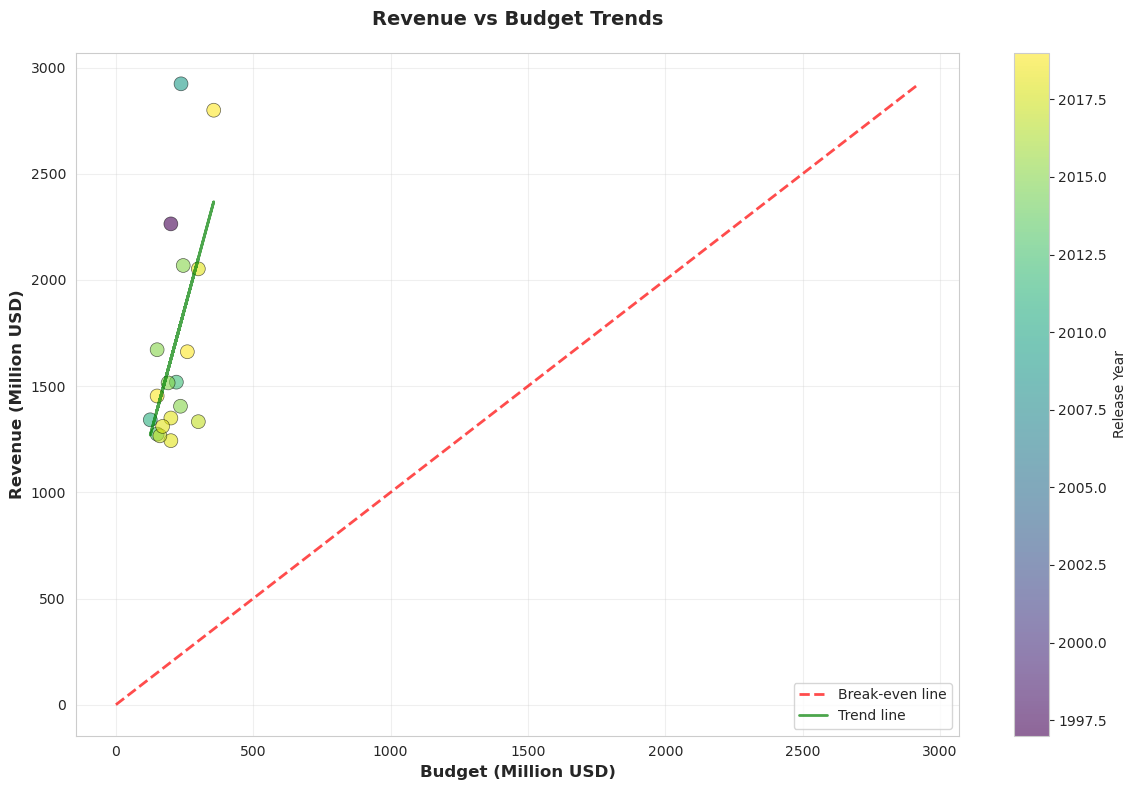


2. Creating ROI Distribution by Genre plot...


/home/jovyan/work/src/viz/visualizations.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x='genre', y='roi', ax=ax, palette='Set2')
/home/jovyan/work/src/viz/visualizations.py:156: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


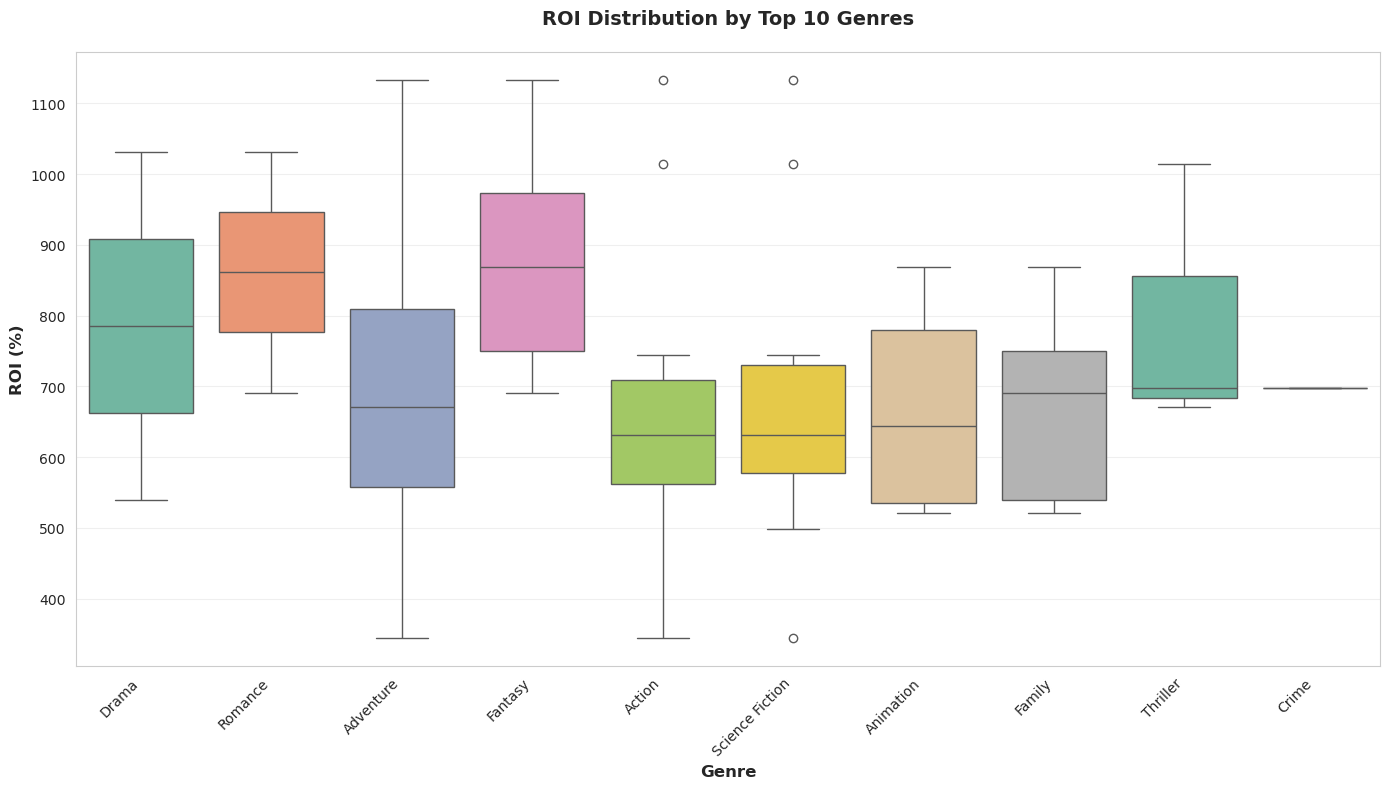


3. Creating Popularity vs Rating plot...


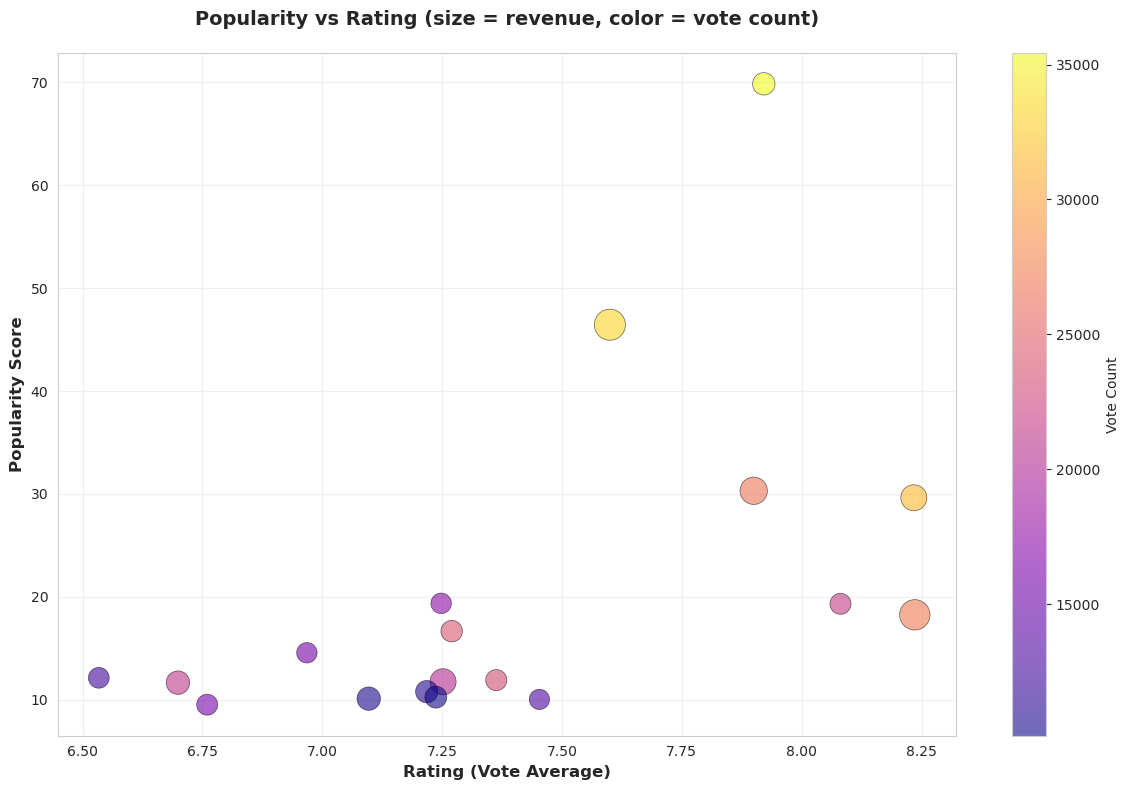


4. Creating Yearly Box Office Trends plot...


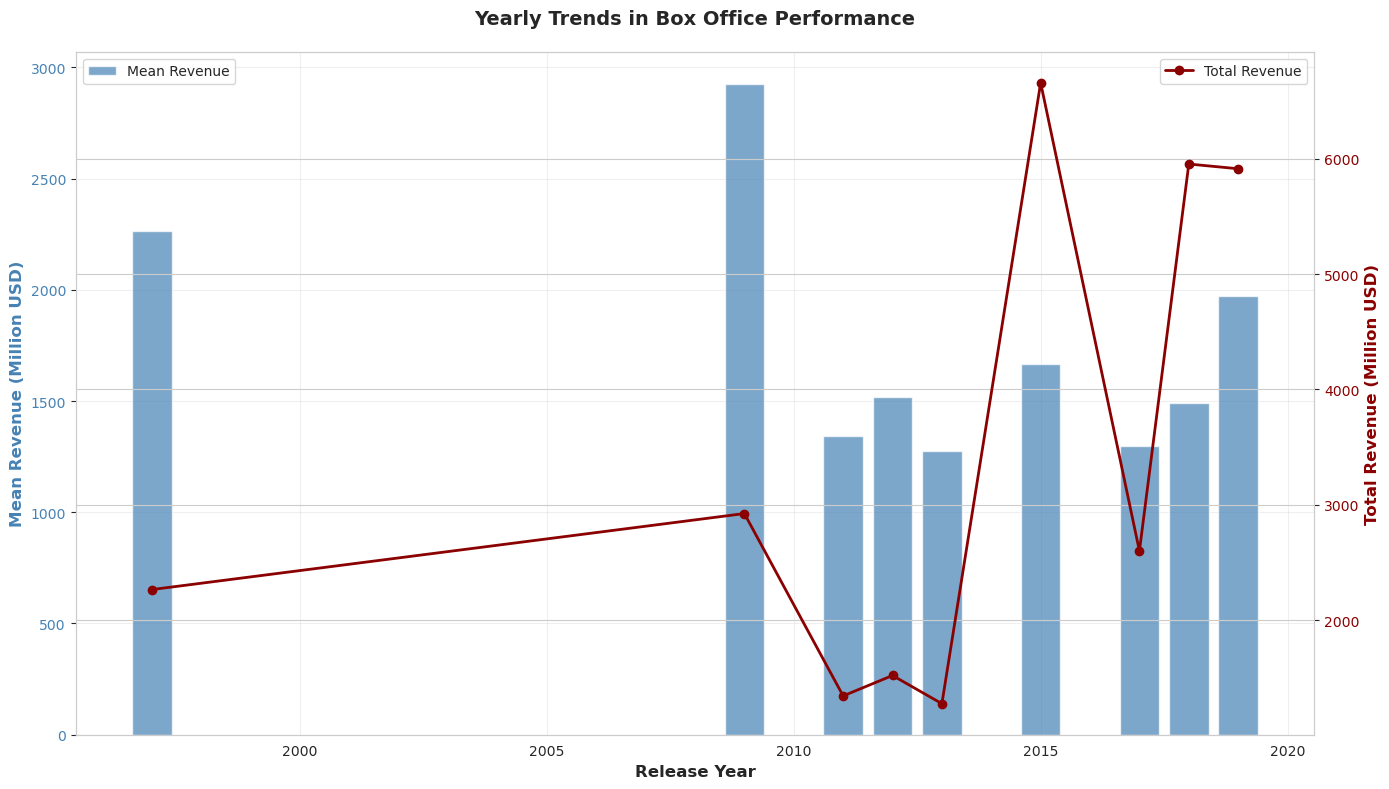


5. Creating Franchise vs Standalone Comparison plot...


/home/jovyan/work/src/viz/visualizations.py:377: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf, x='movie_type', y=metric, ax=ax, palette=palette)
/home/jovyan/work/src/viz/visualizations.py:377: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf, x='movie_type', y=metric, ax=ax, palette=palette)
/home/jovyan/work/src/viz/visualizations.py:377: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf, x='movie_type', y=metric, ax=ax, palette=palette)
/home/jovyan/work/src/viz/visualizations.py:377: FutureWarning: 

Passing `palette

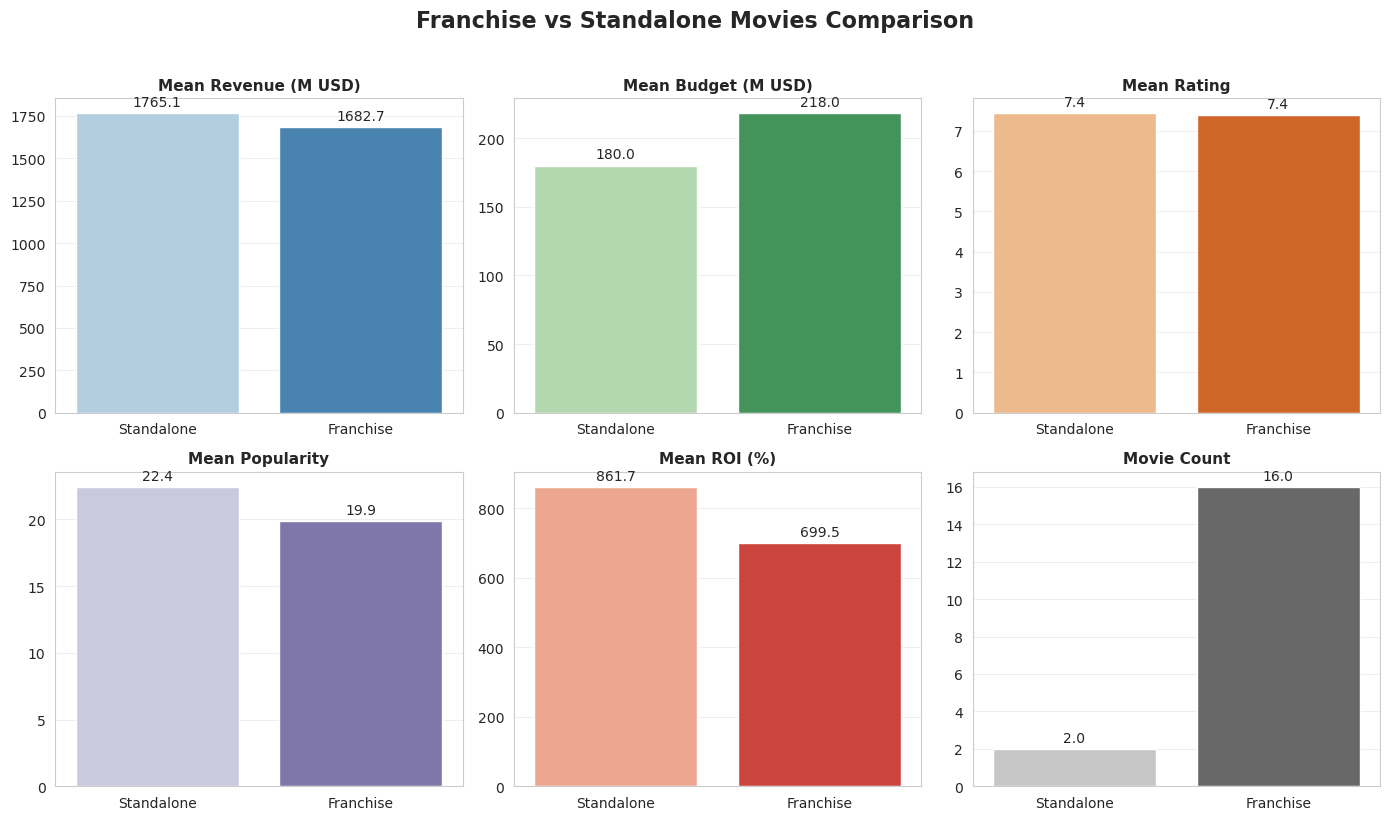


All visualizations created successfully!


In [22]:
from src.viz.visualizations import MovieVisualizer
import matplotlib.pyplot as plt

# Initialize visualizer
viz = MovieVisualizer(spark=spark)

print("="*80)
print("DATA VISUALIZATIONS")
print("="*80)

# 1. Revenue vs Budget Trends
print("\n1. Creating Revenue vs Budget Trends plot...")
fig1 = viz.plot_revenue_vs_budget(cleaned_df, figsize=(12, 8))
plt.show()

# 2. ROI Distribution by Genre
print("\n2. Creating ROI Distribution by Genre plot...")
fig2 = viz.plot_roi_by_genre(cleaned_df, top_n_genres=10, figsize=(14, 8))
plt.show()

# 3. Popularity vs Rating
print("\n3. Creating Popularity vs Rating plot...")
fig3 = viz.plot_popularity_vs_rating(cleaned_df, min_votes=10, figsize=(12, 8))
plt.show()

# 4. Yearly Trends in Box Office Performance
print("\n4. Creating Yearly Box Office Trends plot...")
fig4 = viz.plot_yearly_box_office_trends(cleaned_df, figsize=(14, 8))
plt.show()

# 5. Franchise vs Standalone Comparison
print("\n5. Creating Franchise vs Standalone Comparison plot...")
fig5 = viz.plot_franchise_vs_standalone(cleaned_df, figsize=(14, 8))
plt.show()

print("\n" + "="*80)
print("All visualizations created successfully!")
print("="*80)


## Cleanup

Run this cell when you're done to stop the Spark session.

In [ ]:
# Stop SparkSession
# stop_spark_session()
# print("Spark session stopped")